# Loading data

In [29]:
import numpy as np
import copy 
import glob
import os

cms=1/2.54
########################
#Parameter
########################

verbose=False
Folder='./'
DataNameBasis='/'

irf=0.2 #IRF depends on calibration




########################
#Load and parse the file
########################
File=glob.glob(Folder+DataNameBasis+"*.img")
#File=File[0:3]
file=open(File[0],mode='rb')
data_raw=file.read()
IndexDataStart=np.frombuffer(data_raw[2:4], dtype=np.dtype('u2'))[0]+64

if verbose==True:
    print(data_raw[64:IndexDataStart].decode())

########################
#Recover image basic parameter
########################
BitDepth=np.frombuffer(data_raw[12:13], dtype=np.dtype('u1'))
BytesPerPixel=int(data_raw[data_raw.find(b'BytesPerPixel')+14: \
                                      data_raw.find(b'BytesPerPixel')+15].decode())

#It can't be that there is more than 2048 pixel which should then show as as 4 char
#so we split to only slect the right amount of character
ImgWidth=int(data_raw[data_raw.find(b'HWidth')+8: \
                                      data_raw.find(b'HWidth')+13].decode().split('"')[0])
ImgHeight=int(data_raw[data_raw.find(b'VWidth')+8: \
                                      data_raw.find(b'VWidth')+13].decode().split('"')[0])

IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart


print('Shape of image (widht x height): {}x{} px'.format(ImgWidth,ImgHeight))


########################
#Recover the unit for the different axis
########################

TimeUnit=data_raw[data_raw.find(b'ScalingYUnit'): \
                                      data_raw.find(b'ScalingYUnit')+18].decode().split('"')
XUnit=data_raw[data_raw.find(b'ScalingXUnit'): \
                                      data_raw.find(b'ScalingXUnit')+18].decode().split('"')

if TimeUnit[1]=='' :
    Time=np.linspace(-1,1,ImgHeight)
    TimeUnit[1]='a.u'
if XUnit[1]=='':
    x=np.linspace(-1,1,ImgWidth)
    XUnit[1]='a.u'
elif TimeUnit[1]=='a.u'  and XUnit[1]!='':
    x=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
elif TimeUnit[1]!='' and XUnit[1]!='':
    temp=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
    x=temp[0:ImgWidth]
    Time=temp[ImgWidth:]



########################
#Finally load the data
########################

if BytesPerPixel==4:
    Data= np.reshape(np.frombuffer(data_raw[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')),
                      newshape=(ImgHeight, ImgWidth))
elif BytesPerPixel==2:
    Data= np.reshape(np.frombuffer(data_raw[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')),
                      newshape=(ImgHeight, ImgWidth))





Data_kin=np.zeros([len(File),ImgHeight,ImgWidth])
TimeExp=np.zeros([len(File),1])
TimeFile=np.zeros([len(File),ImgHeight])

for i,File_temp in enumerate(File):
    file=open(File_temp,mode='rb')
    data_raw_kin=file.read()
    IndexDataStart=np.frombuffer(data_raw_kin[2:4], dtype=np.dtype('u2'))[0]+64
    IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart
    
    TimeTemp=data_raw_kin[data_raw_kin.find(b'Time'): \
                                      data_raw_kin.find(b'Time')+16].decode().split('"')
    try:
        TimeExp[i]=int(TimeTemp[1].split(':')[0])*3600+int(TimeTemp[1].split(':')[1])*60+int(TimeTemp[1].split(':')[2])
    except:
        if i==1:
            TimeExp[0]=0
        TimeExp[i]=float(TimeTemp[1].split('ms')[0])
    if BytesPerPixel==4:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
    elif BytesPerPixel==2:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))
    Data_kin[i,:,:]=temp
    TimeFile[i,:]=np.frombuffer(data_raw_kin[IndexDataEnd:], dtype=np.dtype('<f4'))[ImgWidth:]

TimeExp=np.round(TimeExp-TimeExp[0],0)/1000

Shape of image (widht x height): 1024x508 px


# Fitting to given function

## Fitting function definition

In [30]:
########################
# Function
########################

ScalingParameterG=[1,100,10]
def Gaussian(x,a,b,c):
	return np.array(a*ScalingParameterG[0] * np.exp(-0.5*np.power((x-b*ScalingParameterG[1])/(c*ScalingParameterG[2]),2)),dtype='float32')


# Utility function

def Step(x):
	'''Heaviside step function'''
	step = np.ones_like(x, dtype='float')
	step[x<0] = 0
	step[x==0] = 0.5
	return step

# Base function definition 

def IRFGaussian(x,a,b,c):
	return np.array(a*np.exp(-0.5*np.power((x-b)/(c),2)),dtype='float32')

def BiexpFunc(x,a,b,c,d):
     return np.array(Step(x)*(a * np.exp( -(x/(b))) +
                    c * np.exp( -(x/(d)))),dtype='float32')

def TriexpFunc(x,a,b,c,d,e,f):
     return np.array((a * np.exp( -(x/(b))) +
                    c * np.exp( -(x/(d)))+e * np.exp( -(x/(f)))),dtype='float32')

# Fitting function
def FittingFunction(x,a_gauss,b_gauss,c_gauss,a_exp,b_exp,c_exp,d_exp,g_cst):
	temp_gauss=IRFGaussian(x,a_gauss,b_gauss,c_gauss)
	temp_exp=BiexpFunc(x,a_exp,b_exp,c_exp,d_exp)+g_cst
	return np.convolve(temp_gauss,temp_exp,'same')

def FittingFunctionDiffEvolution(para,data):
	x=data[0]
	y=data[1]
	return np.sum((y-FittingFunction(x,para[0],para[1],para[2],para[3],para[4],para[5],para[6],para[7]))**2,dtype='float32')

def FittingFunction2(x,a_gauss,b_gauss,c_gauss,a_exp,b_exp,c_exp,d_exp,e_exp,f_exp,g_cst):
    temp_gauss=IRFGaussian(x,a_gauss,b_gauss,c_gauss)
    temp_exp=TriexpFunc(x,a_exp,b_exp,c_exp,d_exp,e_exp,f_exp)+g_cst
    return np.convolve(temp_gauss,temp_exp,'same')

def FittingFunctionDiffEvolution2(para,data):
    x=data[0]
    y=data[1]
    return np.sum((y-FittingFunction2(x,para[0],para[1],para[2],para[3],para[4],para[5],para[6],para[7],para[8],para[9]))**2,dtype='float32')

# Fitting function
def FittingFunctionNoIRF(x,a_exp,b_exp,c_exp,d_exp,g_cst):
	temp_exp=BiexpFunc(x,a_exp,b_exp,c_exp,d_exp)+g_cst
	return temp_exp

def FittingFunctionDiffEvolutionNoIRF(para,data):
	x=data[0]
	y=data[1]
	return np.sum((y-FittingFunction(x,para[0],para[1],para[2],para[3],para[4]))**2,dtype='float32')


## Fitting procedure (Gaussian)

In [31]:
import pandas as pd

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing
from scipy.stats import chi2
from scipy.signal import savgol_filter

def FittingGaussian(i):
    '''This function take a 2D image containing raw streak data and transform, find the peak poistion and return it. 
    The data is assumed to have the following dimension (Time,Wavelength).'''
    
    Data=Data_kin[i,:,:]
    Time_max_index=np.unravel_index(Data[:,:].argmax(), Data[:,:].shape)[0]
    data_fit_Gaussian=np.squeeze(np.mean(Data[Time_max_index-30:Time_max_index+30,:],0))    

    #Normalise the data
    
    IntNormaGaussian=np.max(data_fit_Gaussian)
    data_fit_Gaussian=data_fit_Gaussian/IntNormaGaussian
    
    popt, pcov = curve_fit(Gaussian,x,data_fit_Gaussian,p0=[1,x[np.argmax(data_fit_Gaussian)]/100,5])
    
    result=pd.DataFrame()

    result['FitWavelength']=Gaussian(x,popt[0],popt[1],popt[2])
    result['ExpWavelength']=data_fit_Gaussian
    result['MaxIntTh']=np.max(Gaussian(x,popt[0],popt[1],popt[2]))*IntNormaGaussian
    result['MaxInt']=np.max(data_fit_Gaussian)*IntNormaGaussian
    result['WavePeak']=popt[1]*ScalingParameterG[1]
    result['Rsquare']=1-(np.sum(np.power(result['ExpWavelength']-result['FitWavelength'],2))/
                         np.sum(np.power(result['ExpWavelength']-np.mean(result['ExpWavelength']),2)))
    
    return result

WavePeak=np.empty(len(File))
Max_int_Theoritical=np.empty(len(File))
Max_int=np.empty(len(File))
Rsq_kin=np.empty(len(File))

Data_fit_Wavelength=np.empty([len(File),len(x)],dtype='float32')
Data_exp_Wavelength=np.empty([len(File),len(x)],dtype='float32')
for i in range(len(File)):
    ResultGaussianFit=FittingGaussian(i)
    WavePeak[i]=ResultGaussianFit['WavePeak'][0]
    Max_int_Theoritical[i]=ResultGaussianFit['MaxIntTh'][0]
    Max_int[i]=ResultGaussianFit['MaxInt'][0]
    Rsq_kin[i]=ResultGaussianFit['Rsquare'][0]
    Data_fit_Wavelength[i,:]=ResultGaussianFit['FitWavelength']
    Data_exp_Wavelength[i,:]=ResultGaussianFit['ExpWavelength']


## Fitting procedure (Lifetime)

In [45]:
WavelengthAvg=20
WindowTime_fit=50
TimeMin=100

def FittingLifetime(Index):
    (i,Wavepeak)=Index
    Data=np.squeeze(Data_kin[i,:,:])

    #################### 
    # Slicing data
    #################### 
    # We now take a slice in time at the theoritical maximum and try to fit a multiexponential
    
    temp=np.squeeze(Data[:,np.abs(x-Wavepeak).argmin()-WavelengthAvg:np.abs(x-Wavepeak).argmin()+WavelengthAvg])
    data_temp_kin=np.squeeze((np.sum(temp,1)))

    #data_temp_kin=np.squeeze((np.mean(Data_kin[i,:,:],1)))
    Index_Time_min=np.argmin(np.abs(data_temp_kin-np.max(data_temp_kin)))-TimeMin
    if Index_Time_min<0:
        Index_Time_min=0
    Index_Time_max=Index_Time_min+np.argmin(np.abs(WindowTime_fit-TimeFile[i,Index_Time_min:]))
    if Index_Time_max>len(TimeFile[i,:]):
         Index_Time_max=len(TimeFile[i,:])
    if verbose==True:
        print('Time fitting wavelength:{}-{}'.format(TimeFile[i,Index_Time_min]-np.min(TimeFile[i,:])),
              TimeFile[i,Index_Time_max]-np.min(TimeFile[i,:]))

    # Timing offset
    
    Time_fit=TimeFile[i,Index_Time_min:Index_Time_max]-np.min(TimeFile[i,Index_Time_min:Index_Time_max])

    TimeGlobal=TimeFile[i,:]-np.min(TimeFile[i,:])
    Index_Time_Max_Global=np.argmin(np.abs(TimeGlobal-np.max(TimeGlobal)))
    #################### 
    # Data correction
    ####################
    IntNorma=np.max(data_temp_kin-np.min(data_temp_kin))
    
    #Data_fit=savgol_filter((data_temp_kin-np.min(data_temp_kin))/IntNorma,window_length=5,polyorder=1)
    # or
    Data_fit=data_temp_kin/IntNorma
    

    ###############
    #Bi- exponential fit
    ###############
    
    bounds=[[1E-6,4],[1E-6,Time_fit[-1]],[0.1,0.5],
            [1E-6,4],[1E-6,10*Time_fit[-1]],[1E-6,4],[1E-6,10*Time_fit[-1]],[1E-4,2E-3]]
    resultfit=differential_evolution(func=FittingFunctionDiffEvolution,bounds=bounds,
                                     args=((Time_fit,Data_fit[Index_Time_min:Index_Time_max]),),
                                     strategy='best1exp',maxiter=5000,tol=0.001)
    popt=resultfit['x']

    #popt, pcov = curve_fit(FittingFunction,Time_fit[:Index_Time_Max],Data_fit[:Index_Time_Max],p0=popt)

    result=pd.DataFrame()
    
    result['FitData']=FittingFunction(Time_fit,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7])
    result['ExpData']=Data_fit[Index_Time_min:Index_Time_max]
    result['Time']=Time_fit
    result['ChiSqr']=np.nansum(np.power(result['ExpData']-result['FitData'],2,dtype='float32')/result['FitData'])
    result['LifeTimeFit_1']=np.sort([popt[4],popt[6]])[0]
    result['LifeTimeFit_2']=np.sort([popt[4],popt[6]])[1]
    result['LifeTimeFit_3']=0
    
    ###############
    #Bi- exponential fit No IRF
    ###############
    '''
    bounds=[[1E-6,4],[1E-6,10*Time_fit[-1]],[1E-6,4],[1E-6,10*Time_fit[-1]],[1E-4,2E-3]]
    resultfit=differential_evolution(func=FittingFunctionDiffEvolutionNoIRF,bounds=bounds,
                                     args=((Time_fit,Data_fit[Index_Time_min:Index_Time_max]),),
                                     strategy='best1exp',maxiter=5000,tol=0.001)
    popt=resultfit['x']

    #popt, pcov = curve_fit(FittingFunction,Time_fit[:Index_Time_Max],Data_fit[:Index_Time_Max],p0=popt)

    result=pd.DataFrame()
    
    result['FitData']=FittingFunctionDiffEvolutionNoIRF(Time_fit,popt[0],popt[1],popt[2],popt[3],popt[4])
    result['ExpData']=Data_fit[Index_Time_min:Index_Time_max]
    result['Time']=Time_fit
    result['ChiSqr']=np.nansum(np.power(result['ExpData']-result['FitData'],2,dtype='float32')/result['FitData'])/ChiSquareCritical
    result['LifeTimeFit_1']=np.sort([popt[1],popt[3]])[0]
    result['LifeTimeFit_2']=np.sort([popt[1],popt[3]])[1]
    result['LifeTimeFit_3']=0
    '''
    ###############
    #Tri- exponential fit
    ###############
    '''
    bounds=[[1E-6,1],[1E-6,Time_fit[-1]],[1E-6,2],[1E-6,1],[1E-6,10*Time_fit[-1]],
            [1E-6,1],[1E-6,10*Time_fit[-1]],[1E-6,1],[1,10*Time_fit[-1]],[1E-4,2E-3]]

    resultfit=differential_evolution(func=FittingFunctionDiffEvolution2,bounds=bounds,
                                     args=((Time_fit,Data_fit[Index_Time_min:Index_Time_max]),),
                                     strategy='best1bin',maxiter=5000,tol=0.00001)
    popt=resultfit['x']
    #popt, pcov = curve_fit(FittingFunction2,Time_fit,Data_fit[Index_Time_min:Index_Time_max],p0=popt)
    result=pd.DataFrame()

    result['FitData']=FittingFunction2(Time_fit,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],popt[8],popt[9])
    result['ExpData']=Data_fit[Index_Time_min:Index_Time_max]
    result['Time']=Time_fit
    result['ChiSqr']=np.nansum(np.power(result['ExpData']-result['FitData'],2,dtype='float32')/result['FitData'])
    result['LifeTimeFit_1']=np.sort([popt[4],popt[6],popt[8]])[0]
    result['LifeTimeFit_2']=np.sort([popt[4],popt[6],popt[8]])[1]
    result['LifeTimeFit_3']=np.sort([popt[4],popt[6],popt[8]])[2]
    '''

    ###############
    #Return
    ###############

    return result


Data_fit_s=np.empty([len(File),Time.shape[0]],dtype='float32')
Data_exp_s=np.empty([len(File),Time.shape[0]],dtype='float32')
Time_fit=np.empty([len(File),Time.shape[0]],dtype='float32')
ChiSqr=np.empty(len(File))
tau_fit=np.zeros([len(File),4])

ArgsProcLifetime=[]
DataFrameTemp=pd.DataFrame()
for i in range(len(File)):
        ResultLifetimeFit=FittingLifetime((i,WavePeak[i]))

        #Recover result

        tau_fit[i,:]=[ResultLifetimeFit['LifeTimeFit_1'][0],ResultLifetimeFit['LifeTimeFit_2'][0],
                      ResultLifetimeFit['LifeTimeFit_3'][0],ResultLifetimeFit['ChiSqr'][0]]
        
        DataFrameTemp['Time_'+str(i)]=ResultLifetimeFit['Time'][:]
        DataFrameTemp['Fit_'+str(i)]=ResultLifetimeFit['FitData'][:]
        DataFrameTemp['Exp_'+str(i)]=ResultLifetimeFit['ExpData'][:]        


# Plotting result

[[1.55456478e-01 1.21909640e+01 0.00000000e+00            inf]
 [1.11800544e-01 1.40965178e+01 0.00000000e+00            inf]
 [4.81983854e-04 6.83575951e-01 0.00000000e+00            inf]
 [2.98255193e-03 5.42320907e-01 0.00000000e+00            inf]]


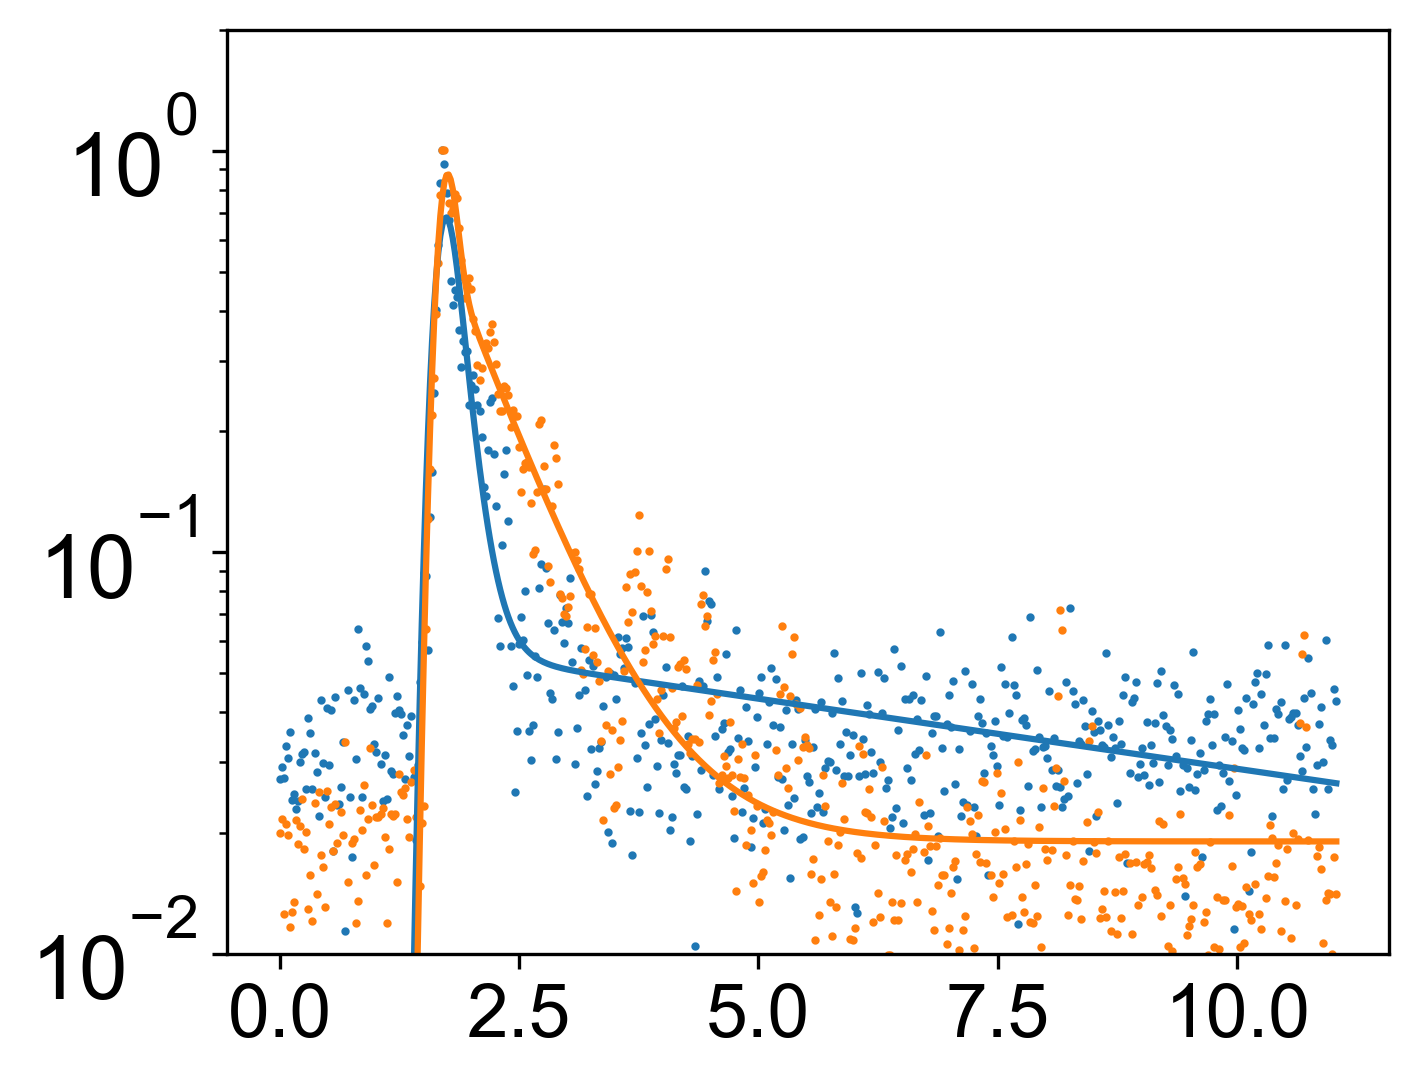

In [48]:
import matplotlib as mat
import matplotlib.pyplot as plt

mat.rcParams.update({'font.size':18,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':18,'ytick.labelsize':21,
                     'figure.dpi':300,'savefig.dpi':300,'figure.figsize':(5,4)})

fig1,ax1=plt.subplots(1,1)

ax1.plot(DataFrameTemp['Time_0'],DataFrameTemp['Fit_0'])
ax1.scatter(DataFrameTemp['Time_0'],DataFrameTemp['Exp_0'],s=1)
ax1.plot(DataFrameTemp['Time_2'],DataFrameTemp['Fit_2'])
ax1.scatter(DataFrameTemp['Time_2'],DataFrameTemp['Exp_2'],s=1)
ax1.set_yscale('log')
ax1.set_ylim([1E-2,2E0])
print(tau_fit)

(0.0001, 2.0)

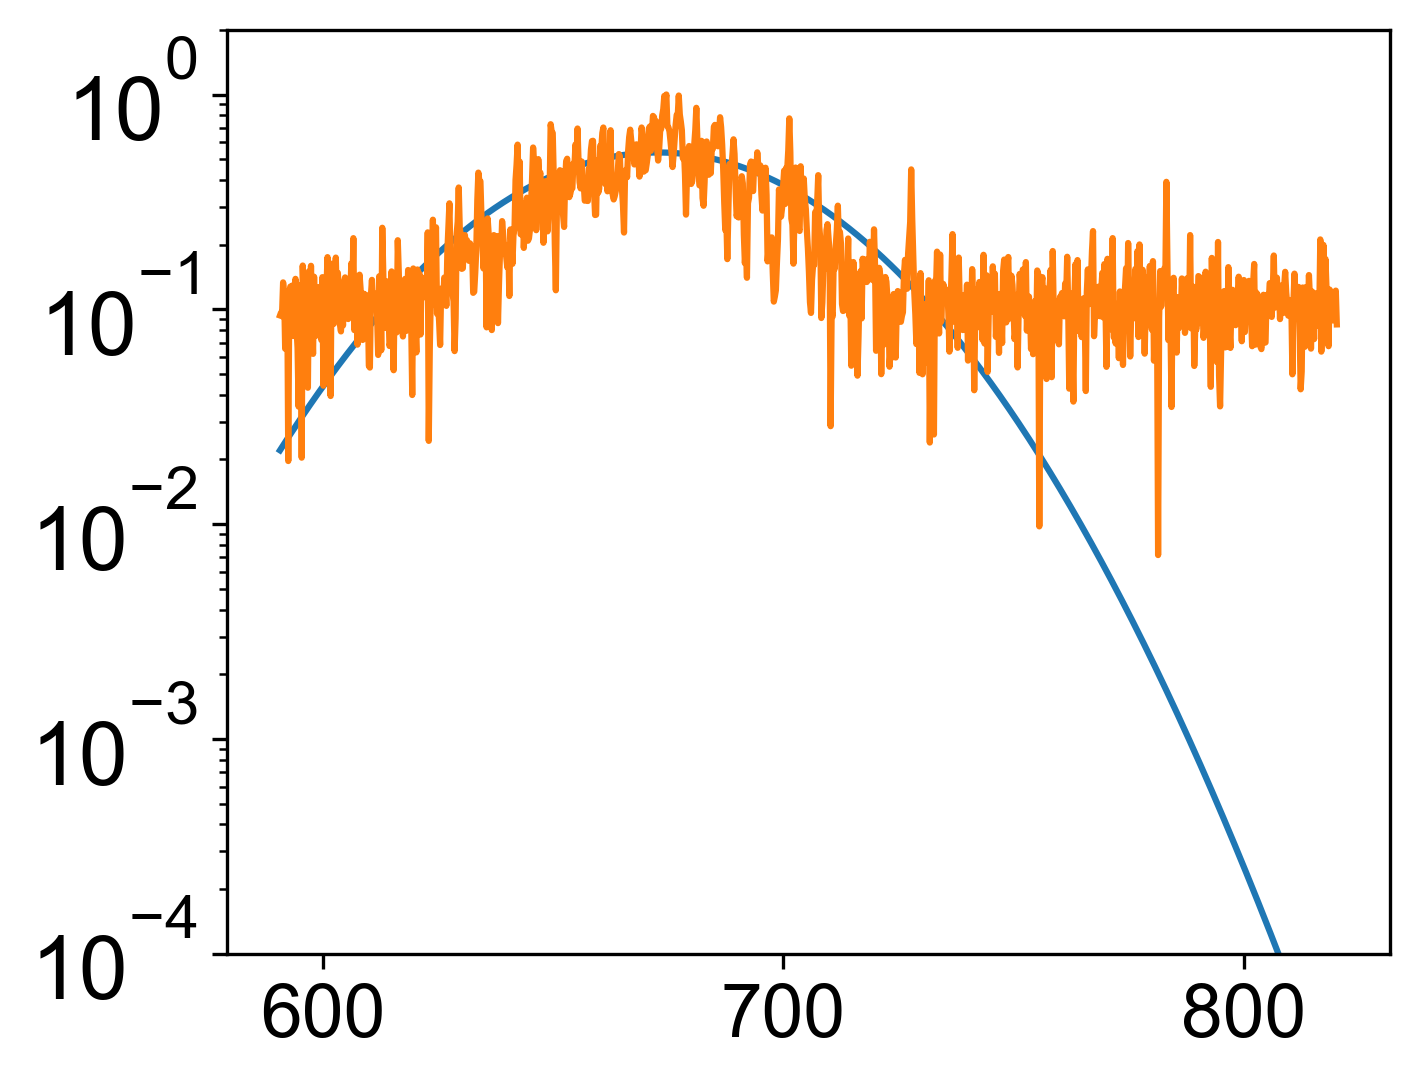

In [34]:
mat.rcParams.update({'font.size':18,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':18,'ytick.labelsize':21,
                     'figure.dpi':300,'savefig.dpi':300,'figure.figsize':(5,4)})

fig1,ax1=plt.subplots(1,1)

ax1.plot(x,Data_fit_Wavelength[0,:])
ax1.plot(x,Data_exp_Wavelength[0,:])

ax1.set_yscale('log')
ax1.set_ylim([1E-4,2E0])

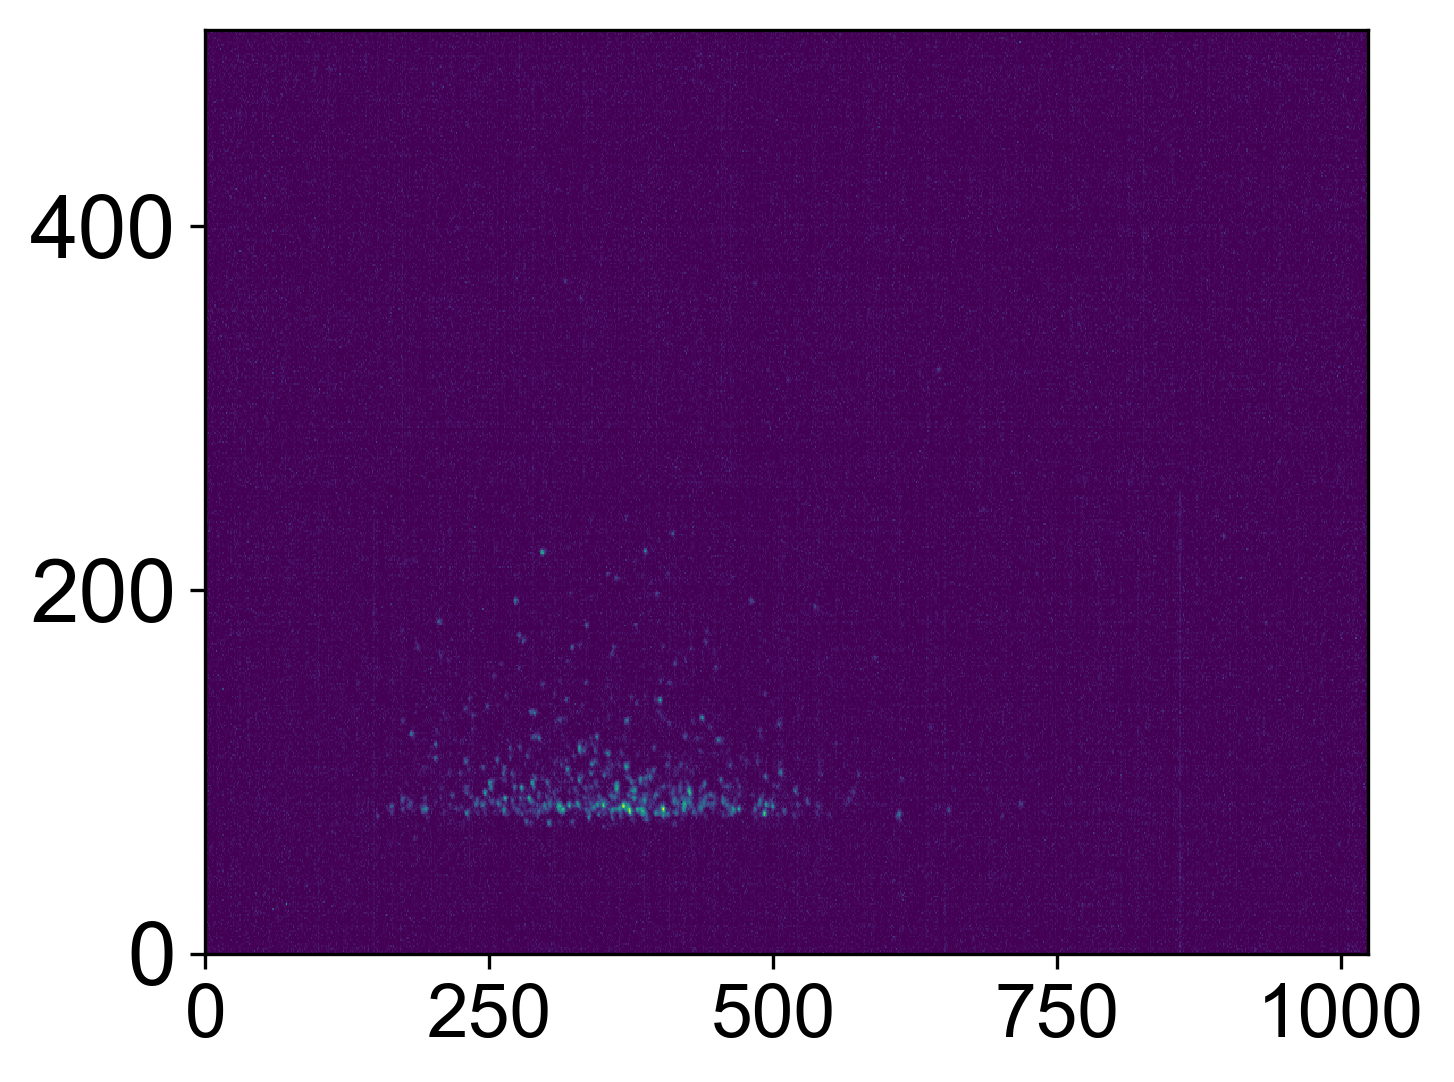

In [35]:
mat.rcParams.update({'font.size':18,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':18,'ytick.labelsize':21,
                     'figure.dpi':300,'savefig.dpi':300,'figure.figsize':(5,4)})

fig1,ax1=plt.subplots(1,1)

ax1.pcolormesh(Data_kin[0,:,:])



